In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import time
import pickle
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from data_preprocessing import filter_valid_persons
from file_utils import preprocess_videos, save_dataset
from high_level_features import compute_window_stats, get_high_level_features, compute_frames_velocities_and_accelerations, compute_points_distances, compute_angle_features

In [7]:
RANDOM_STATE = 42
INCLUDE_FACE_KEYPOINTS = True
FILL_MISSING_TS_VALUE = np.nan
IMPUTE_AND_FILTER_POSES = {
    "moving_avg_window": 5,
}
FILTER_PEOPLE = {
    "min_frames": 60,
    "min_variation": 0.2,
}
SLIDING_WINDOW = "size30_overlap50_step2"
INCLUDE_WINDOW_STATISTICS = False
DATASET_INSTANCES = [*Path("resources/annotations").glob("*.json")]
DATASET_INSTANCES.sort()
TEST_SIZE = 0.2
BALANCE_TECHNIQUE = "undersample"
DATASET_OUTPUT_DIR = Path("resources/medium_dataset_swstep2")

## Preparazione del dataset

- Split delle time series individuali in base ai frames non individuati. Assegnazione di nuovi track_id agli split diversi dal primo.

- **Interpolazione lineare dei missing values e filtro moving average sugli ultimi 5 frames.**

- Normalizzazione dei keypoints nell'intervallo [0-1] e clipping nell'intervallo 0-1.

- Rimozione di tutte le time series con meno di 60 frames e una variazione totale media < 0.2.
    > I valori di tale variazione sono stati scalati nello stesso range [0-1] tramite uno scaler che è stato fittato e serializzato nella cartella del dataset.

- Si considerano finestre da 30 frames, che includono i keypoints di una singola persona, con overlap del 50%.

- Si impiegano solo raw features e poche statistiche (media e deviazione standard).

Si salta un frame tra due adiacenti in modo da coprire artificiosamente un intervallo di 60 frames (a una frequenza di campionamento più bassa). I frames saltati vengono utilizzati per costruire un'altra finestra.

Si fa random undersampling se i dati sono sbilanciati tra le classi.

In [4]:
videos = preprocess_videos(DATASET_INSTANCES, INCLUDE_FACE_KEYPOINTS, FILL_MISSING_TS_VALUE, IMPUTE_AND_FILTER_POSES)

(1 / 66) Loading TS from resources\annotations\bachata_Antoni & Estefania - Bachata social dancing ｜ Summer Sensual Days 2023 (Rovinj) [m8TZRzP_MhY].mp4.json...
(1 / 66) TS loaded in 9.2s. Filtering...
(1 / 66) TS filtered in 3.2s. Scaling...
(1 / 66) TS scaled in 3.4s. Computing stats...
(1 / 66) Stats computed in 1.1s.
(2 / 66) Loading TS from resources\annotations\bachata_Antoni & Naja - Bachata social dancing ｜ Summer Sensual Days 2023 (Rovinj) [YTFh-FJ-q_U].mp4.json...
(2 / 66) TS loaded in 7.9s. Filtering...
(2 / 66) TS filtered in 2.5s. Scaling...
(2 / 66) TS scaled in 2.8s. Computing stats...
(2 / 66) Stats computed in 0.9s.
(3 / 66) Loading TS from resources\annotations\bachata_Arnold & Wandaisha - Bachata social dancing ｜ Summer Sensual Days 2018 [PUxKL-1zrVk].mp4.json...
(3 / 66) TS loaded in 5.2s. Filtering...
(3 / 66) TS filtered in 2.1s. Scaling...
(3 / 66) TS scaled in 2.2s. Computing stats...
(3 / 66) Stats computed in 1.0s.
(4 / 66) Loading TS from resources\annotation

In [5]:
all_videos = {video_name: video["time_series"] for video_name, video in videos.items()}
all_stats = {video_name: video["stats"] for video_name, video in videos.items()}
scaler, all_filtered_videos = filter_valid_persons(all_videos, all_stats, FILTER_PEOPLE["min_frames"], FILTER_PEOPLE["min_variation"])

In [6]:
Path(DATASET_OUTPUT_DIR).mkdir(exist_ok=True)
with open(DATASET_OUTPUT_DIR / "scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

In [7]:
save_dataset(all_filtered_videos, DATASET_OUTPUT_DIR / "dataset", INCLUDE_FACE_KEYPOINTS, SLIDING_WINDOW)

1 / 66 Processing bachata_Antoni & Estefania - Bachata social dancing ｜ Summer Sensual Days 2023 (Rovinj) [m8TZRzP_MhY].mp4.json...
1 / 66 Done in 6.6s. Saved to resources\medium_dataset_swstep2\dataset\bachata_Antoni & Estefania - Bachata social dancing ｜ Summer Sensual Days 2023 (Rovinj) [m8TZRzP_MhY].mp4.json.csv
2 / 66 Processing bachata_Antoni & Naja - Bachata social dancing ｜ Summer Sensual Days 2023 (Rovinj) [YTFh-FJ-q_U].mp4.json...
2 / 66 Done in 32.0s. Saved to resources\medium_dataset_swstep2\dataset\bachata_Antoni & Naja - Bachata social dancing ｜ Summer Sensual Days 2023 (Rovinj) [YTFh-FJ-q_U].mp4.json.csv
3 / 66 Processing bachata_Arnold & Wandaisha - Bachata social dancing ｜ Summer Sensual Days 2018 [PUxKL-1zrVk].mp4.json...
3 / 66 Done in 12.9s. Saved to resources\medium_dataset_swstep2\dataset\bachata_Arnold & Wandaisha - Bachata social dancing ｜ Summer Sensual Days 2018 [PUxKL-1zrVk].mp4.json.csv
4 / 66 Processing bachata_Bachata Dance 2019 [GY2fE5xr6XU].mp4.json...
4

## Caricamento del dataset

In [8]:
def load_dataset(dataset_path, test_size: float, shuffle_dataset: bool, random_state: int = 42):
    all_instances = [
        pd.read_csv(path)
        for path in Path(dataset_path).rglob("*.csv") 
    ]

    all_instances = [(df.iloc[0].label, df) for df in all_instances if df.shape[0] > 0]

    salsa_instances = [instance for label, instance in all_instances if label == "salsa"]
    bachata_instances = [instance for label, instance in all_instances if label == "bachata"]
    salsa_train_dfs, salsa_test_dfs = train_test_split(salsa_instances, test_size=test_size/2, random_state=random_state)
    bachata_train_dfs, bachata_test_dfs = train_test_split(bachata_instances, test_size=test_size/2, random_state=random_state)

    print(f"Salsa train|test: {len(salsa_train_dfs)}|{len(salsa_test_dfs)}")
    print(f"Bachata train|test: {len(bachata_train_dfs)}|{len(bachata_test_dfs)}")

    training_set = pd.concat(salsa_train_dfs + bachata_train_dfs)
    test_set = pd.concat(salsa_test_dfs + bachata_test_dfs)

    print(f"Training set shape {training_set.shape}")
    print(f"Test set shape {test_set.shape}")

    training_set["label"].value_counts().plot(kind="bar", title="Training set class distribution")
    plt.show()
    print(training_set["label"].value_counts())

    test_set["label"].value_counts().plot(kind="bar", title="Test set class distribution")
    plt.show()
    print(test_set["label"].value_counts())

    label_map = {"salsa": 1, "bachata": 0}
    training_set["class"] = training_set["label"].map(label_map)
    test_set["class"] = test_set["label"].map(label_map)
    
    if shuffle_dataset:
        training_set = shuffle(training_set, random_state=random_state)
        test_set = shuffle(test_set, random_state=random_state)
        
    training_set.reset_index(drop=True, inplace=True)
    test_set.reset_index(drop=True, inplace=True)

    X_train = training_set.drop(["track_id", "first_frame", "last_frame", "name", "label", "class", "window_size"], axis=1)
    y_train = training_set["class"]

    X_test = test_set.drop(["track_id", "first_frame", "last_frame", "name", "label", "class", "window_size"], axis=1)
    y_test = test_set["class"]
    
    return X_train, X_test, y_train, y_test

Salsa train|test: 29|4
Bachata train|test: 29|4
Training set shape (34692, 1696)
Test set shape (5595, 1696)


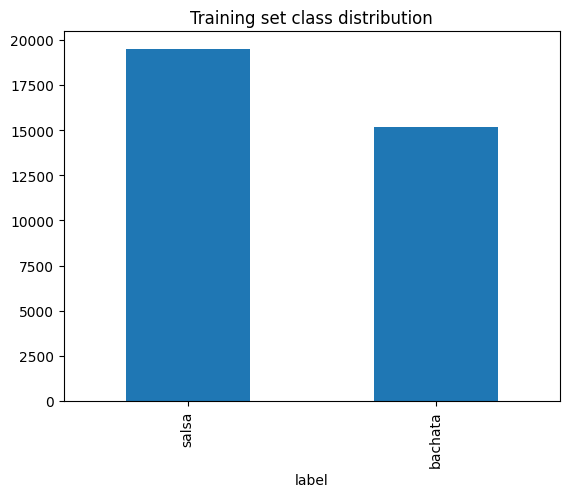

label
salsa      19490
bachata    15202
Name: count, dtype: int64


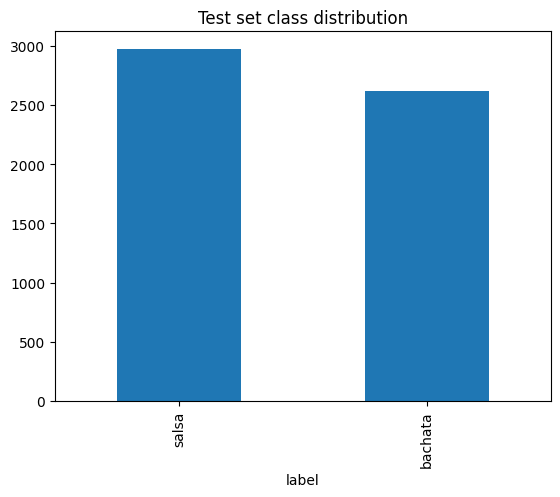

label
salsa      2973
bachata    2622
Name: count, dtype: int64


In [9]:
X_train, X_test, y_train, y_test = load_dataset(DATASET_OUTPUT_DIR / "dataset", TEST_SIZE, shuffle_dataset=True, random_state=RANDOM_STATE)

In [10]:
X_train

,conf_avg,conf_std,kp1_x_avg,kp1_y_avg,kp2_x_avg,kp2_y_avg,kp3_x_avg,kp3_y_avg,kp4_x_avg,kp4_y_avg,...,f30_kp8_conf,f30_kp9_conf,f30_kp10_conf,f30_kp11_conf,f30_kp12_conf,f30_kp13_conf,f30_kp14_conf,f30_kp15_conf,f30_kp16_conf,f30_kp17_conf
0,0.807824,0.026299,0.562504,0.098995,0.665878,0.080481,0.525678,0.079740,0.848087,0.095098,...,0.93637,0.91642,0.79794,0.75606,0.99414,0.99356,0.99265,0.99186,0.98646,0.98526
1,0.718217,0.067621,0.639574,0.090875,0.645858,0.070758,0.657365,0.058673,0.671080,0.085752,...,0.18683,0.88779,0.15098,0.74420,0.94862,0.98218,0.91977,0.97811,0.87285,0.95328
2,0.861399,0.042680,0.413375,0.107882,0.422203,0.090869,0.439782,0.082044,0.515047,0.097509,...,0.98619,0.55983,0.96509,0.55460,0.99806,0.99383,0.99849,0.99416,0.99609,0.98890
3,0.930840,0.009987,0.489034,0.099953,0.511788,0.080305,0.469374,0.077435,0.566225,0.087544,...,0.99515,0.99223,0.99201,0.98849,0.99912,0.99907,0.99883,0.99883,0.99551,0.99579
4,0.736726,0.098520,0.647276,0.094504,0.788188,0.167176,0.614024,0.072871,0.068173,0.170396,...,0.28550,0.70701,0.25307,0.58044,0.80846,0.87099,0.76761,0.84052,0.65006,0.71540
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34687,0.503445,0.109648,0.673110,0.222661,0.119781,0.023982,0.635343,0.199465,0.340707,0.129348,...,0.41117,0.49597,0.19313,0.24894,0.95296,0.95873,0.95237,0.96163,0.95536,0.96250
34688,0.904709,0.015236,0.517837,0.096644,0.483650,0.070849,0.487130,0.076480,0.333331,0.085188,...,0.53410,0.97093,0.14934,0.73034,0.98044,0.99383,0.84784,0.95098,0.62330,0.81577
34689,0.808213,0.051107,0.301602,0.099517,0.008591,0.036856,0.601947,0.055776,0.524566,0.089910,...,0.84533,0.96625,0.54054,0.81989,0.98469,0.99202,0.91294,0.95773,0.71715,0.83312
34690,0.792660,0.067024,0.386262,0.125757,0.417785,0.105656,0.120729,0.060002,0.530980,0.096695,...,0.98566,0.63940,0.96886,0.61621,0.99739,0.99216,0.99821,0.99296,0.99600,0.98868


## Training

In [11]:
def display_models_metrics(models, X_train, X_test, y_train, y_test):
  for model in models:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        print(f"##### {model} #####")
        sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d")
        plt.show()
        print(classification_report(y_test, y_pred))

In [7]:
rus = RandomUnderSampler(random_state=RANDOM_STATE)

models = [
    make_pipeline(
        rus,
        StandardScaler(),
        SGDClassifier(random_state=RANDOM_STATE),
    ),
    make_pipeline(
        rus,
        RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1, class_weight="balanced"),
    ),
    make_pipeline(
        rus,
        HistGradientBoostingClassifier(random_state=RANDOM_STATE),
    ),
    make_pipeline(
        rus,
        StandardScaler(),
        SVC(kernel="rbf", random_state=RANDOM_STATE, cache_size=500),
    ),
    make_pipeline(
        rus,
        AdaBoostClassifier(random_state=RANDOM_STATE, algorithm="SAMME")
    )
]

##### Pipeline(steps=[('randomundersampler', RandomUnderSampler(random_state=42)),
                ('standardscaler', StandardScaler()),
                ('sgdclassifier', SGDClassifier(random_state=42))]) #####
Accuracy:  0.6309475396502643
Precision:  0.7526178010471204
Recall:  0.5802219979818365
F1 Score:  0.6552706552706553


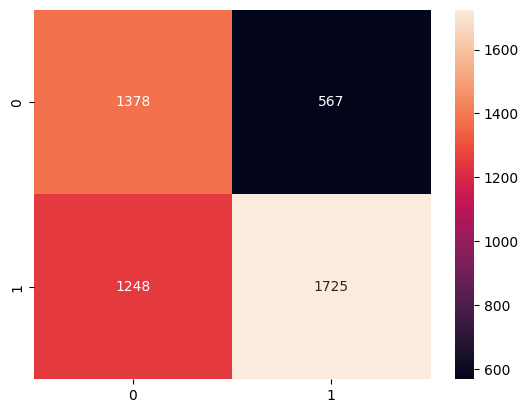

              precision    recall  f1-score   support

           0       0.52      0.71      0.60      1945
           1       0.75      0.58      0.66      2973

    accuracy                           0.63      4918
   macro avg       0.64      0.64      0.63      4918
weighted avg       0.66      0.63      0.63      4918

##### Pipeline(steps=[('randomundersampler', RandomUnderSampler(random_state=42)),
                ('randomforestclassifier',
                 RandomForestClassifier(class_weight='balanced', n_jobs=-1,
                                        random_state=42))]) #####
Accuracy:  0.7139080927206182
Precision:  0.7757042253521127
Recall:  0.7410023545240498
F1 Score:  0.7579563048339928


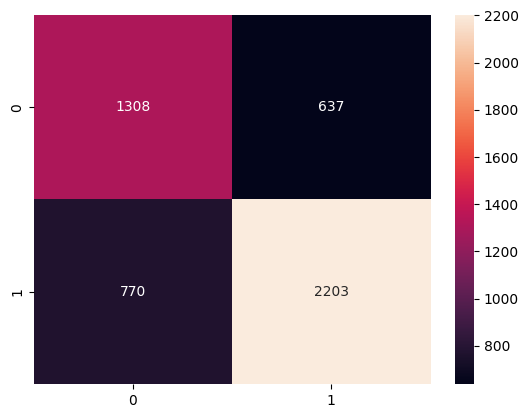

              precision    recall  f1-score   support

           0       0.63      0.67      0.65      1945
           1       0.78      0.74      0.76      2973

    accuracy                           0.71      4918
   macro avg       0.70      0.71      0.70      4918
weighted avg       0.72      0.71      0.72      4918

##### Pipeline(steps=[('randomundersampler', RandomUnderSampler(random_state=42)),
                ('histgradientboostingclassifier',
                 HistGradientBoostingClassifier(random_state=42))]) #####
Accuracy:  0.7053680357869052
Precision:  0.777292576419214
Recall:  0.7184661957618567
F1 Score:  0.746722600943891


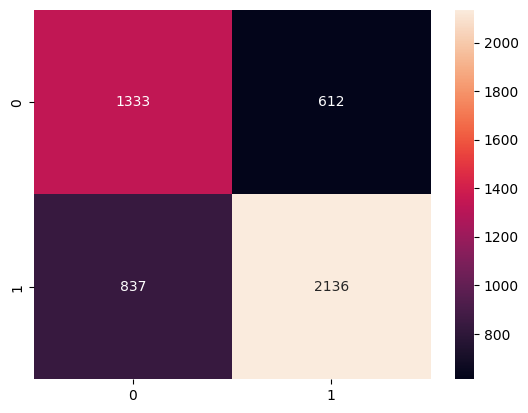

              precision    recall  f1-score   support

           0       0.61      0.69      0.65      1945
           1       0.78      0.72      0.75      2973

    accuracy                           0.71      4918
   macro avg       0.70      0.70      0.70      4918
weighted avg       0.71      0.71      0.71      4918

##### Pipeline(steps=[('randomundersampler', RandomUnderSampler(random_state=42)),
                ('standardscaler', StandardScaler()),
                ('svc', SVC(cache_size=500, random_state=42))]) #####
Accuracy:  0.73627490849939
Precision:  0.8062865497076024
Recall:  0.7420114362596704
F1 Score:  0.7728148537397093


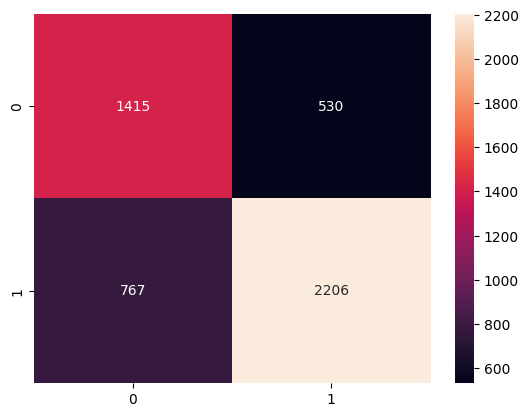

              precision    recall  f1-score   support

           0       0.65      0.73      0.69      1945
           1       0.81      0.74      0.77      2973

    accuracy                           0.74      4918
   macro avg       0.73      0.73      0.73      4918
weighted avg       0.74      0.74      0.74      4918

##### Pipeline(steps=[('randomundersampler', RandomUnderSampler(random_state=42)),
                ('adaboostclassifier',
                 AdaBoostClassifier(algorithm='SAMME', random_state=42))]) #####
Accuracy:  0.6630744204961366
Precision:  0.7466266866566716
Recall:  0.6700302724520686
F1 Score:  0.7062577557170714


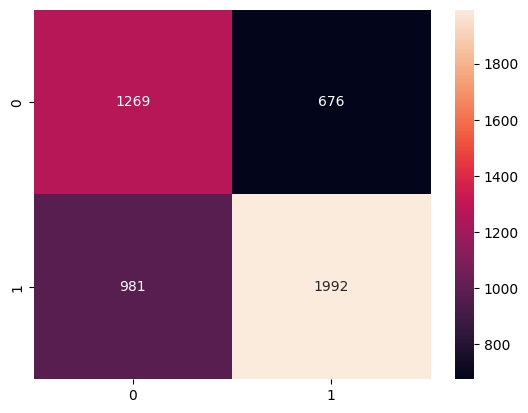

              precision    recall  f1-score   support

           0       0.56      0.65      0.61      1945
           1       0.75      0.67      0.71      2973

    accuracy                           0.66      4918
   macro avg       0.66      0.66      0.66      4918
weighted avg       0.67      0.66      0.67      4918



In [14]:
display_models_metrics(models, X_train, X_test, y_train, y_test)

## Estrazione features di alto livello

- Rappresentazione delle velocità e accelerazioni dei keypoint tra frames consecutivi;
- Distanze tra keypoints di uno stesso frame;
- Angoli calcolati fra tre keypoints:
    - Gomiti (2)
    - Tra braccia e busto (2)
    - Tra gambe e busto (2)
    - Ginocchia (2)

In [12]:
compute_frames_velocities_and_accelerations(X_train, include_face_keypoints=INCLUDE_FACE_KEYPOINTS)

,vel1_kp1_x,vel2_kp1_x,vel3_kp1_x,vel4_kp1_x,vel5_kp1_x,vel6_kp1_x,vel7_kp1_x,vel8_kp1_x,vel9_kp1_x,vel10_kp1_x,...,acc19_kp17_y,acc20_kp17_y,acc21_kp17_y,acc22_kp17_y,acc23_kp17_y,acc24_kp17_y,acc25_kp17_y,acc26_kp17_y,acc27_kp17_y,acc28_kp17_y
0,-0.001288,-0.026095,-0.026750,-0.023657,-0.034736,-0.034722,-0.021518,-0.003874,0.020890,0.028397,...,-0.004302,-0.004518,-0.002698,-0.000001,-0.006449,-0.001312,0.002274,-0.000341,0.000448,-0.000429
1,0.068655,0.106065,0.071303,-0.039610,-0.023563,-0.040288,-0.042503,-0.060047,0.001718,-0.002771,...,-0.000164,0.009974,-0.001776,0.002330,-0.004397,0.000629,-0.009231,0.004722,0.000324,0.007885
2,0.013822,0.028464,0.005241,-0.025445,-0.004845,0.062269,0.052666,-0.007166,-0.106029,-0.123804,...,0.000089,-0.002336,-0.011858,-0.011479,0.016787,0.029925,0.003177,-0.024428,-0.004338,-0.000249
3,0.080331,0.119567,-0.017158,-0.140556,-0.113049,-0.041240,-0.012141,-0.017754,-0.017030,-0.000495,...,0.005614,-0.012024,-0.018878,-0.000951,0.000983,-0.000427,-0.000289,-0.000312,0.003698,-0.002352
4,-0.059130,-0.010936,-0.006965,-0.000492,0.001758,-0.000721,-0.002735,-0.007142,-0.002653,-0.014280,...,0.000868,0.011734,-0.001265,-0.002166,-0.002024,0.000112,0.001525,0.002926,-0.002923,0.015834
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34687,-0.001945,-0.003421,0.012683,-0.026383,-0.053245,-0.101616,-0.119236,-0.058634,0.086933,0.093858,...,-0.010951,0.011357,-0.015249,0.012398,-0.007047,0.002306,0.011794,-0.012558,-0.007856,0.005024
34688,0.014117,0.011495,0.018010,0.018291,-0.000019,-0.018703,-0.021558,-0.013931,-0.006658,-0.001259,...,0.015650,-0.012108,-0.010838,0.002050,0.000717,-0.004915,-0.004800,-0.005282,0.011300,0.002938
34689,0.019680,0.066359,0.042939,0.038777,0.014626,-0.002676,-0.002247,0.004172,0.009353,0.003661,...,-0.004081,0.000385,-0.003265,-0.002325,-0.002911,-0.011487,-0.007671,0.015136,-0.000714,0.032294
34690,0.032251,0.004727,0.029168,0.014776,-0.052123,-0.080476,-0.098289,-0.098808,-0.086618,-0.064822,...,0.032348,0.026930,-0.015907,-0.006702,0.011931,-0.002015,0.009395,-0.007590,-0.008650,-0.019192


In [13]:
compute_points_distances(X_train)

,f1_eucliddist_6_7,f1_eucliddist_6_8,f1_eucliddist_8_10,f1_eucliddist_7_9,f1_eucliddist_9_11,f1_eucliddist_6_12,f1_eucliddist_7_13,f1_eucliddist_12_13,f1_eucliddist_12_14,f1_eucliddist_14_16,...,f30_eucliddist_8_10,f30_eucliddist_7_9,f30_eucliddist_9_11,f30_eucliddist_6_12,f30_eucliddist_7_13,f30_eucliddist_12_13,f30_eucliddist_12_14,f30_eucliddist_14_16,f30_eucliddist_15_17,f30_eucliddist_13_15
0,0.389457,0.187195,0.109953,0.259385,0.050709,0.270534,0.281756,0.253079,0.236030,0.209335,...,0.114535,0.147461,0.089187,0.270241,0.258975,0.184996,0.223934,0.199142,0.199696,0.224297
1,0.378598,0.148906,0.356012,0.269485,0.286430,0.350502,0.310472,0.243200,0.304527,0.244783,...,0.233917,0.206048,0.240984,0.285716,0.281572,0.178298,0.227654,0.210971,0.259013,0.227600
2,0.231769,0.160026,0.208005,0.061129,0.148142,0.257348,0.285005,0.177327,0.244123,0.239065,...,0.090378,0.162361,0.027535,0.272939,0.299180,0.031535,0.314687,0.298399,0.284967,0.226663
3,0.247861,0.159742,0.134151,0.178536,0.134504,0.427881,0.433624,0.157591,0.042837,0.149928,...,0.081905,0.189335,0.031080,0.311392,0.280865,0.259031,0.222461,0.213242,0.217509,0.216044
4,0.200294,0.130541,0.344737,0.350694,0.118781,0.303813,0.284960,0.131902,0.268732,0.207418,...,0.045247,0.116984,0.196788,0.273321,0.280197,0.309767,0.239332,0.249358,0.226075,0.254931
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34687,0.404386,0.177882,0.145035,0.150876,0.214228,0.243233,0.290322,0.240042,0.210418,0.214576,...,1.048000,0.249343,0.781606,0.295303,0.270293,0.317042,0.227198,0.221771,0.222654,0.238671
34688,0.114139,0.172467,0.173883,0.313968,0.302651,0.295447,0.345846,0.139758,0.232111,0.209180,...,0.177930,0.256474,0.039050,0.346212,0.370880,0.373684,0.256932,0.203046,0.231405,0.304410
34689,0.440965,0.176118,0.158798,0.225381,0.166152,0.259880,0.276525,0.279162,0.236545,0.220165,...,0.114851,0.137898,0.124666,0.290766,0.299860,0.045153,0.221771,0.218356,0.237468,0.230300
34690,0.529087,0.170238,0.570017,0.173416,0.077024,0.300897,0.275260,0.357563,0.222609,0.208589,...,0.227869,0.272210,0.314766,0.300772,0.300603,0.141704,0.346811,0.241674,0.248324,0.225862


In [14]:
compute_angle_features(X_train)

c:\Users\tonto\OneDrive\Desktop\magistrale\ml\projects\dance-classifier\high_level_features.py:101: RuntimeWarning: invalid value encountered in divide
  np.arccos((dot_product / normalization_factor).clip(-1, 1)),
c:\Users\tonto\OneDrive\Desktop\magistrale\ml\projects\dance-classifier\high_level_features.py:101: RuntimeWarning: invalid value encountered in divide
  np.arccos((dot_product / normalization_factor).clip(-1, 1)),
c:\Users\tonto\OneDrive\Desktop\magistrale\ml\projects\dance-classifier\high_level_features.py:101: RuntimeWarning: invalid value encountered in divide
  np.arccos((dot_product / normalization_factor).clip(-1, 1)),
c:\Users\tonto\OneDrive\Desktop\magistrale\ml\projects\dance-classifier\high_level_features.py:101: RuntimeWarning: invalid value encountered in divide
  np.arccos((dot_product / normalization_factor).clip(-1, 1)),
c:\Users\tonto\OneDrive\Desktop\magistrale\ml\projects\dance-classifier\high_level_features.py:101: RuntimeWarning: invalid value encountere

,f1_angle_6_8_10,f2_angle_6_8_10,f3_angle_6_8_10,f4_angle_6_8_10,f5_angle_6_8_10,f6_angle_6_8_10,f7_angle_6_8_10,f8_angle_6_8_10,f9_angle_6_8_10,f10_angle_6_8_10,...,f21_angle_13_15_17,f22_angle_13_15_17,f23_angle_13_15_17,f24_angle_13_15_17,f25_angle_13_15_17,f26_angle_13_15_17,f27_angle_13_15_17,f28_angle_13_15_17,f29_angle_13_15_17,f30_angle_13_15_17
0,12.040088,10.165052,9.727612,5.603321,8.139250,39.952990,110.672789,131.967751,137.541359,151.264382,...,171.073567,170.986428,173.566212,174.041449,171.539176,172.984645,176.230097,175.079679,173.629144,177.893119
1,63.043744,146.306543,28.906102,15.911940,13.586735,23.210572,64.211289,31.834121,23.963097,32.118561,...,144.349529,138.472320,142.718329,151.683730,157.510738,160.752570,160.913067,157.555913,160.971406,158.249820
2,132.714370,140.488623,144.638190,139.960565,135.489018,120.831217,114.074414,124.177351,111.646072,133.312245,...,153.815827,134.553982,99.816377,77.268349,91.384226,102.905605,109.988032,122.281352,145.747884,159.364883
3,120.850935,104.609616,82.623162,93.153838,140.216464,169.349803,175.822234,172.589536,170.624031,171.882945,...,178.567669,160.825554,163.142316,170.433621,175.220709,177.629724,178.969339,175.132600,169.585846,150.656138
4,148.042910,162.903927,159.955424,153.431608,137.746145,112.407245,85.271453,72.430459,67.322070,64.259737,...,137.204244,137.097654,140.525377,140.739627,143.957606,146.362879,145.158643,144.853366,143.259426,151.832202
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34687,17.312831,17.872993,5.833891,0.003354,20.890172,55.125194,56.437224,17.311750,67.837690,94.917540,...,156.121423,152.946770,152.940416,152.343529,160.289162,171.121992,171.247854,165.165419,167.246229,173.539295
34688,131.640995,119.487631,122.853714,138.661127,147.297939,150.078157,144.259769,144.267036,143.658900,145.989805,...,106.947107,126.190129,140.072562,146.869052,153.757274,156.216831,141.605242,138.043473,156.925908,174.809175
34689,162.804204,160.546661,129.731195,112.988236,57.377459,88.458024,91.973235,114.827737,109.792290,108.730110,...,155.953903,170.210266,176.037998,165.301416,154.693928,137.292738,121.455292,119.354297,133.994111,151.394223
34690,43.446798,50.255314,58.023848,58.052480,57.031353,48.607272,40.843121,28.498987,1.628832,17.155800,...,169.981969,166.267716,165.839081,164.054609,171.272848,165.846165,140.591292,126.820576,117.795267,118.173945


In [ ]:
X_train = get_high_level_features(X_train, include_face_keypoints=INCLUDE_FACE_KEYPOINTS)

X_test = get_high_level_features(X_test, include_face_keypoints=INCLUDE_FACE_KEYPOINTS)

In [17]:
X_train

,conf_avg,conf_std,kp1_x_avg,kp1_y_avg,kp2_x_avg,kp2_y_avg,kp3_x_avg,kp3_y_avg,kp4_x_avg,kp4_y_avg,...,f30_kp8_conf,f30_kp9_conf,f30_kp10_conf,f30_kp11_conf,f30_kp12_conf,f30_kp13_conf,f30_kp14_conf,f30_kp15_conf,f30_kp16_conf,f30_kp17_conf
0,0.807824,0.026299,0.562504,0.098995,0.665878,0.080481,0.525678,0.079740,0.848087,0.095098,...,0.93637,0.91642,0.79794,0.75606,0.99414,0.99356,0.99265,0.99186,0.98646,0.98526
1,0.718217,0.067621,0.639574,0.090875,0.645858,0.070758,0.657365,0.058673,0.671080,0.085752,...,0.18683,0.88779,0.15098,0.74420,0.94862,0.98218,0.91977,0.97811,0.87285,0.95328
2,0.861399,0.042680,0.413375,0.107882,0.422203,0.090869,0.439782,0.082044,0.515047,0.097509,...,0.98619,0.55983,0.96509,0.55460,0.99806,0.99383,0.99849,0.99416,0.99609,0.98890
3,0.930840,0.009987,0.489034,0.099953,0.511788,0.080305,0.469374,0.077435,0.566225,0.087544,...,0.99515,0.99223,0.99201,0.98849,0.99912,0.99907,0.99883,0.99883,0.99551,0.99579
4,0.736726,0.098520,0.647276,0.094504,0.788188,0.167176,0.614024,0.072871,0.068173,0.170396,...,0.28550,0.70701,0.25307,0.58044,0.80846,0.87099,0.76761,0.84052,0.65006,0.71540
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34687,0.503445,0.109648,0.673110,0.222661,0.119781,0.023982,0.635343,0.199465,0.340707,0.129348,...,0.41117,0.49597,0.19313,0.24894,0.95296,0.95873,0.95237,0.96163,0.95536,0.96250
34688,0.904709,0.015236,0.517837,0.096644,0.483650,0.070849,0.487130,0.076480,0.333331,0.085188,...,0.53410,0.97093,0.14934,0.73034,0.98044,0.99383,0.84784,0.95098,0.62330,0.81577
34689,0.808213,0.051107,0.301602,0.099517,0.008591,0.036856,0.601947,0.055776,0.524566,0.089910,...,0.84533,0.96625,0.54054,0.81989,0.98469,0.99202,0.91294,0.95773,0.71715,0.83312
34690,0.792660,0.067024,0.386262,0.125757,0.417785,0.105656,0.120729,0.060002,0.530980,0.096695,...,0.98566,0.63940,0.96886,0.61621,0.99739,0.99216,0.99821,0.99296,0.99600,0.98868


## Training

Nota: il training può richiedere più di un'ora.

##### Pipeline(steps=[('randomundersampler', RandomUnderSampler(random_state=42)),
                ('standardscaler', StandardScaler()),
                ('sgdclassifier', SGDClassifier(random_state=42))]) #####
Accuracy:  0.694997966653111
Precision:  0.8029617441382148
Recall:  0.6565758493104609
F1 Score:  0.7224278312361214


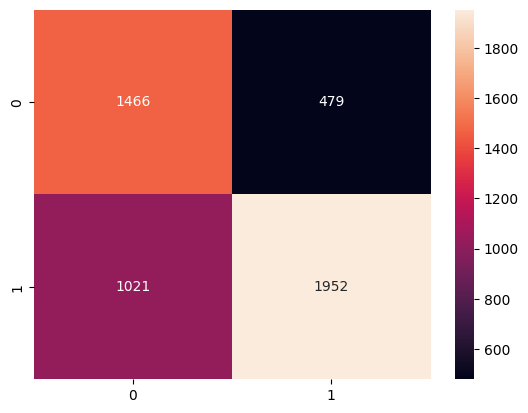

              precision    recall  f1-score   support

           0       0.59      0.75      0.66      1945
           1       0.80      0.66      0.72      2973

    accuracy                           0.69      4918
   macro avg       0.70      0.71      0.69      4918
weighted avg       0.72      0.69      0.70      4918

##### Pipeline(steps=[('randomundersampler', RandomUnderSampler(random_state=42)),
                ('randomforestclassifier',
                 RandomForestClassifier(class_weight='balanced', n_jobs=-1,
                                        random_state=42))]) #####
Accuracy:  0.7240748271655144
Precision:  0.7964049889948642
Recall:  0.7302388160107636
F1 Score:  0.7618880505351816


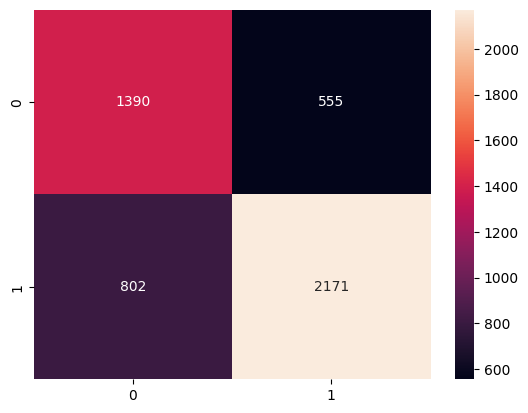

              precision    recall  f1-score   support

           0       0.63      0.71      0.67      1945
           1       0.80      0.73      0.76      2973

    accuracy                           0.72      4918
   macro avg       0.72      0.72      0.72      4918
weighted avg       0.73      0.72      0.73      4918

##### Pipeline(steps=[('randomundersampler', RandomUnderSampler(random_state=42)),
                ('histgradientboostingclassifier',
                 HistGradientBoostingClassifier(random_state=42))]) #####
Accuracy:  0.6962179747864986
Precision:  0.7754189944134078
Recall:  0.7003027245206862
F1 Score:  0.735949098621421


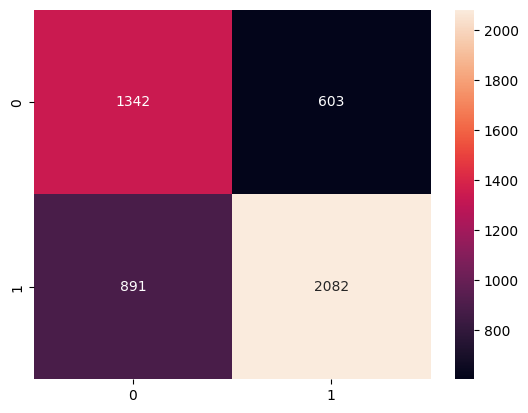

              precision    recall  f1-score   support

           0       0.60      0.69      0.64      1945
           1       0.78      0.70      0.74      2973

    accuracy                           0.70      4918
   macro avg       0.69      0.70      0.69      4918
weighted avg       0.71      0.70      0.70      4918

##### Pipeline(steps=[('randomundersampler', RandomUnderSampler(random_state=42)),
                ('standardscaler', StandardScaler()),
                ('svc', SVC(cache_size=500, random_state=42))]) #####
Accuracy:  0.7206181374542497
Precision:  0.805736137667304
Recall:  0.708711738984191
F1 Score:  0.7541159627773801


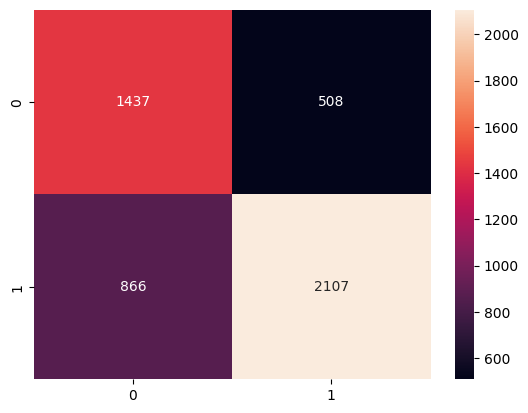

              precision    recall  f1-score   support

           0       0.62      0.74      0.68      1945
           1       0.81      0.71      0.75      2973

    accuracy                           0.72      4918
   macro avg       0.71      0.72      0.72      4918
weighted avg       0.73      0.72      0.72      4918

##### Pipeline(steps=[('randomundersampler', RandomUnderSampler(random_state=42)),
                ('adaboostclassifier',
                 AdaBoostClassifier(algorithm='SAMME', random_state=42))]) #####
Accuracy:  0.6588043920292802
Precision:  0.7497107597377555
Recall:  0.6538849646821393
F1 Score:  0.6985267696730147


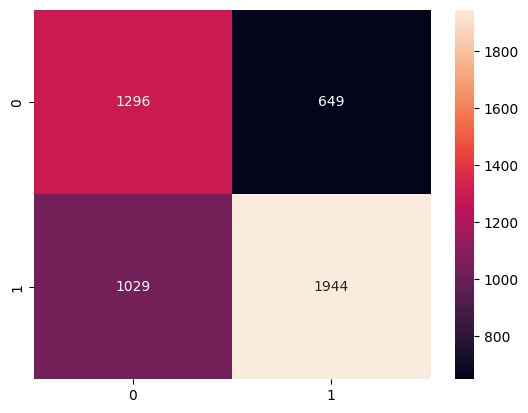

              precision    recall  f1-score   support

           0       0.56      0.67      0.61      1945
           1       0.75      0.65      0.70      2973

    accuracy                           0.66      4918
   macro avg       0.65      0.66      0.65      4918
weighted avg       0.67      0.66      0.66      4918



In [12]:
display_models_metrics(models, X_train, X_test, y_train, y_test)

## Aggiunta di statistiche per singola finestra

Aggiungiamo le seguenti statistiche per ogni sliding window:
- Media e deviazione standard
- Percentili
- Minimo, massimo, range

In [10]:
X_train = compute_window_stats(X_train)

c:\Users\tonto\OneDrive\Desktop\magistrale\ml\projects\dance-classifier\high_level_features.py:171: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[f"vel_kp{i}_y_min"] = X.filter(regex=f"vel.*_kp{i}_y").min(axis=1)
c:\Users\tonto\OneDrive\Desktop\magistrale\ml\projects\dance-classifier\high_level_features.py:172: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[f"vel_kp{i}_y_range"] = X[f"vel_kp{i}_x_max"] - X[f"vel_kp{i}_x_min"]
c:\Users\tonto\OneDrive\Desktop\magistrale\ml\projects\dance-classifier\high_level_features.py:174: P

In [11]:
X_train

,conf_avg,conf_std,kp1_x_avg,kp1_y_avg,kp2_x_avg,kp2_y_avg,kp3_x_avg,kp3_y_avg,kp4_x_avg,kp4_y_avg,...,acc_kp17_x_min,acc_kp17_x_range,acc_kp17_y_avg,acc_kp17_y_std,acc_kp17_y_pct25,acc_kp17_y_pct50,acc_kp17_y_pct75,acc_kp17_y_max,acc_kp17_y_min,acc_kp17_y_range
0,0.883492,0.025515,0.326490,0.129894,0.380009,0.104406,0.293990,0.101371,0.568212,0.098334,...,-0.063232,0.177731,-0.000525,0.013865,-0.005569,-0.000099,0.007531,0.035540,-0.039754,0.075293
1,0.775769,0.049313,0.699169,0.092271,0.570723,0.075175,0.651197,0.073173,0.370609,0.225844,...,-0.117763,0.215017,-0.000698,0.006997,-0.001728,0.000237,0.003627,0.007634,-0.027916,0.035550
2,0.896413,0.013730,0.529302,0.124289,0.689975,0.110714,0.489797,0.106354,0.637207,0.223291,...,-0.104218,0.237253,-0.000689,0.007998,-0.003143,-0.000231,0.004346,0.012959,-0.024059,0.037018
3,0.871256,0.033225,0.155130,0.100635,0.191134,0.075781,0.140457,0.085396,0.304820,0.087870,...,-0.081779,0.170514,-0.000422,0.015517,-0.008851,-0.000714,0.008030,0.033966,-0.025872,0.059838
4,0.854917,0.037197,0.586983,0.079318,0.630102,0.060999,0.745026,0.093181,0.765051,0.075143,...,-0.152552,0.317766,-0.000356,0.005122,-0.002961,-0.000356,0.001709,0.015254,-0.010865,0.026119
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35364,0.503445,0.109648,0.673110,0.222661,0.119781,0.023982,0.635343,0.199465,0.340707,0.129348,...,-0.097518,0.226590,0.000267,0.021373,-0.011390,-0.003885,0.011945,0.046337,-0.055618,0.101955
35365,0.904709,0.015236,0.517837,0.096644,0.483650,0.070849,0.487130,0.076480,0.333331,0.085188,...,-0.060243,0.118063,0.000145,0.006550,-0.004658,0.000170,0.003281,0.015650,-0.012108,0.027758
35366,0.808213,0.051107,0.301602,0.099517,0.008591,0.036856,0.601947,0.055776,0.524566,0.089910,...,-0.112759,0.179684,0.001037,0.009250,-0.002614,-0.000183,0.004168,0.032294,-0.017414,0.049709
35367,0.792660,0.067024,0.386262,0.125757,0.417785,0.105656,0.120729,0.060002,0.530980,0.096695,...,-0.073992,0.204814,-0.000575,0.013763,-0.009061,-0.001559,0.009538,0.032348,-0.023830,0.056177


In [12]:
X_test = compute_window_stats(X_test)

c:\Users\tonto\OneDrive\Desktop\magistrale\ml\projects\dance-classifier\high_level_features.py:171: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[f"vel_kp{i}_y_min"] = X.filter(regex=f"vel.*_kp{i}_y").min(axis=1)
c:\Users\tonto\OneDrive\Desktop\magistrale\ml\projects\dance-classifier\high_level_features.py:172: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[f"vel_kp{i}_y_range"] = X[f"vel_kp{i}_x_max"] - X[f"vel_kp{i}_x_min"]
c:\Users\tonto\OneDrive\Desktop\magistrale\ml\projects\dance-classifier\high_level_features.py:174: P

##### Pipeline(steps=[('randomundersampler', RandomUnderSampler(random_state=42)),
                ('standardscaler', StandardScaler()),
                ('sgdclassifier', SGDClassifier(random_state=42))]) #####


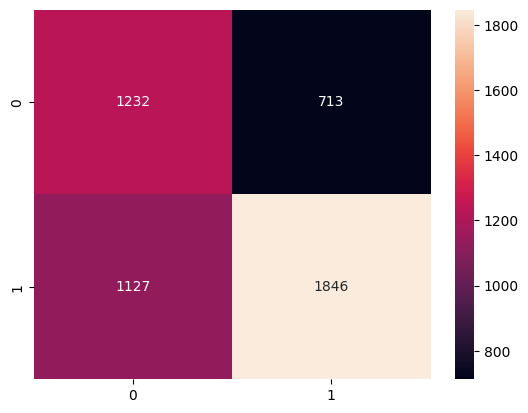

              precision    recall  f1-score   support

           0       0.52      0.63      0.57      1945
           1       0.72      0.62      0.67      2973

    accuracy                           0.63      4918
   macro avg       0.62      0.63      0.62      4918
weighted avg       0.64      0.63      0.63      4918

##### Pipeline(steps=[('randomundersampler', RandomUnderSampler(random_state=42)),
                ('randomforestclassifier',
                 RandomForestClassifier(class_weight='balanced', n_jobs=-1,
                                        random_state=42))]) #####


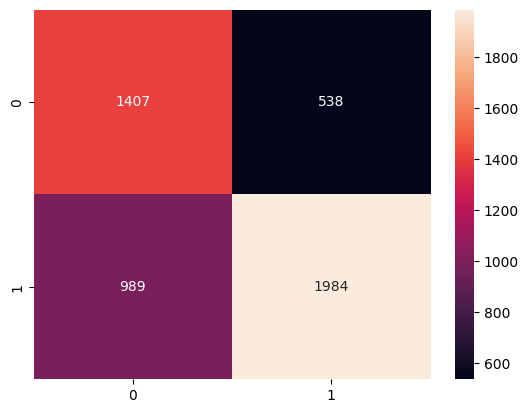

              precision    recall  f1-score   support

           0       0.59      0.72      0.65      1945
           1       0.79      0.67      0.72      2973

    accuracy                           0.69      4918
   macro avg       0.69      0.70      0.69      4918
weighted avg       0.71      0.69      0.69      4918

##### Pipeline(steps=[('randomundersampler', RandomUnderSampler(random_state=42)),
                ('histgradientboostingclassifier',
                 HistGradientBoostingClassifier(random_state=42))]) #####


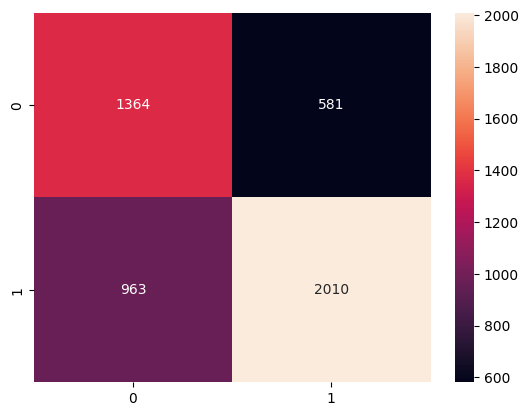

              precision    recall  f1-score   support

           0       0.59      0.70      0.64      1945
           1       0.78      0.68      0.72      2973

    accuracy                           0.69      4918
   macro avg       0.68      0.69      0.68      4918
weighted avg       0.70      0.69      0.69      4918

##### Pipeline(steps=[('randomundersampler', RandomUnderSampler(random_state=42)),
                ('standardscaler', StandardScaler()),
                ('svc', SVC(cache_size=500, random_state=42))]) #####


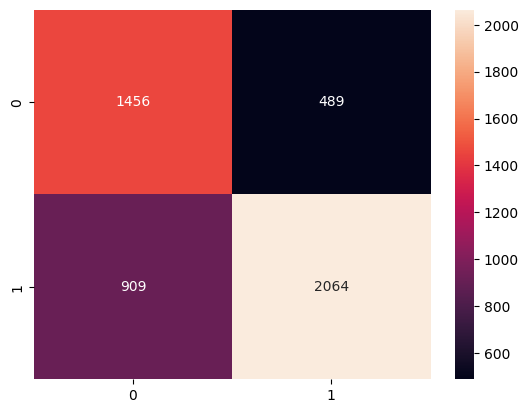

              precision    recall  f1-score   support

           0       0.62      0.75      0.68      1945
           1       0.81      0.69      0.75      2973

    accuracy                           0.72      4918
   macro avg       0.71      0.72      0.71      4918
weighted avg       0.73      0.72      0.72      4918



KeyboardInterrupt: 

In [13]:
display_models_metrics(models, X_train, X_test, y_train, y_test)